In [2]:
import jax
import jax.numpy as jnp
from   jax import jit, vmap
import bayes3d as b3d
import genjax
from   genjax import gen, choice_map, vector_choice_map
from   genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import matplotlib.pyplot as plt
from   matplotlib.collections import LineCollection
import numpy as np
import trimesh
from functools import partial
from pathlib import Path
import os

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

In [3]:
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *

In [4]:
def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose vector [x1,x2,hd] to 3d"""
    x  = v[:2]
    hd = v[ 2]
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd) @ CAM_ALONG_X
    ) 

## Load Meshes

In [5]:
_scaling  = 1e-2
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []

for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)

In [6]:
#|  Let's look at what we just created.
v = Viewer(width=800, cam_pos=(-2.5,-2.5,1), cam_look=(0,0,0), background="#eee", view_as="world")
v.add_mesh(meshes[13].vertices, meshes[13].faces, c=np.array([.99,.99,.99]))
v.add_mesh(meshes[1].vertices, meshes[1].faces, c=np.array([.99,.99,.99]))
v.add_pose(lift_pose(jnp.array([-1.5,0,0])), linewidth=5, scale=0.3)
display(v)

Renderer(camera=PerspectiveCamera(aspect=2.0, children=(DirectionalLight(color='white', intensity=0.6, positio…

## Make renderer

In [7]:
#| Set up the renderer and add the scene mesh
def make_render_function(meshes, w=100, h=100, fx=30, fy =30):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=0.01, far=20.0
    )
    b3d.setup_renderer(intrinsics)
    for mesh in meshes:
        b3d.RENDERER.add_mesh(mesh, center_mesh=True)


    def render(p:"3D Pose", inds=[0]):
        """
        Render a rendered image from a fixed scene that this is closed over.
        The image is made up off 4 channels x,y,z, and
        a "semantic layer" containing object ids.
        """
        p_ = b3d.t3d.inverse_pose(p)
        X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
        return X;

    return render

In [8]:
render = make_render_function(meshes, w=100, h=100, fx=50, fy=50)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


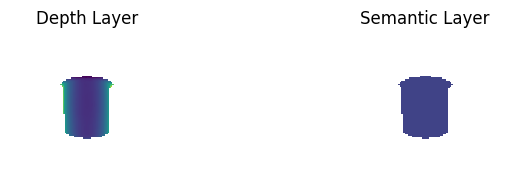

In [9]:
p = jnp.array([-1.5,0,0])
Y = render(lift_pose(p), inds=[13])

im     = np.where(Y[:,:,2]==20.0, jnp.inf, Y[:,:,2])
im_sem = np.where(Y[:,:,3].astype(jnp.float32)==0.0, jnp.inf, Y[:,:,3])

# # ======================
fig, axs = plt.subplots(1,2,figsize=(8,2))
for ax in axs: ax.axis("off")
axs[0].set_title("Depth Layer")
axs[0].imshow(im)
axs[1].set_title("Semantic Layer")
axs[1].imshow(im_sem,vmin=0, vmax=5)

## Make the model

In [10]:
from genjax import tfp_uniform as uniform
from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model
from functools import lru_cache


def make_sensor_model(w:int, zmax:float, sensor_model_type:str="constrained"):
    """
    Returns a sensor model with given filter size `w` and maximal sensor range `zmax`.
    (The corresponding code can be found in `11 - Constrained Likelihood.ipynb`)
    """
    match sensor_model_type:
        case "constrained": return make_constrained_sensor_model(zmax, w)
        case "baseline"   : return make_baseline_sensor_model(zmax, w)
        case _: raise f"Unknown sensor model type: ``{sensor_model_type}''"


sensor_model = make_sensor_model(5, 10.)
help(sensor_model.source)

Help on function sensor_model in module xsight.likelihood:

sensor_model(Y, sig, outlier)
    Constrained sensor model that returns a vector of range measurements conditioned on 
    an image, noise level, and outlier probability.



In [11]:
def make_model(w:int, zmax:float, sensor_model_type:str="constrained"):

    #  Create a sensor model
    #  Note: We need to create a closure here becasue `w` is a *static* argument
    #       and needs to be handled in a special way for GenJAX not to 
    #       complain during JIT compilation. This pattern is similar to JAX's use 
    #       of `static_argnames` in `jit`. We are still working on the API.
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(inds):
        """Isolated time-step model that optionally renders the boxes or not. """

        #  Sample a 2D pose
        #  NOTE: The x bounds are roughly bounding the environment
        #  that is baked into the renderer
        x  = uniform(jnp.array([-5, -5.]), 
                     jnp.array([ 5., 5.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi)       @ "hd"
        p  = pack_2dpose(x, hd)

        #  Sample sensor hyper parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        #  Lift pose to 3D and 
        #  render an image (deterministic)
        Y = render(lift_pose(p), inds)

        #  Sample an image X conditioned on the rendered Y
        #  Here `inline` populates address `@ "X"`; cf. the way 
        #  the sensor model is structured. We don't have 
        #  syntactic sugar for this operation yet.
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

        # NOTE: Try and replace the above line 
        # by the line below and compare the traces 
        # X, _ = sensor_model(Y[:,:,:3], sig, outlier) @ "Sensor"
        
        return p, X, Y
    
    return model

In [12]:
def get_data_logprobs(tr):
    """Return individual log-probabilities of each observed pixel value."""
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds  = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

In [13]:
def make_constraints(X, sensor_model_type="constrained"):
    """Return a choicemap with sensor constraints"""
    assert X.shape[-1] == 3 or X.shape[-1] == 4
    
    X  = X[...,:3].reshape(-1,3)
    D  = jnp.linalg.norm(X, axis=-1)
    ch = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  D if sensor_model_type == "constrained" else X
            }) 
    })
    return ch

In [14]:
def _eval_pose_and_sensor(key, tr, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': adjust_angle(p[2]),
        'sig':     sig,
        'outlier': outlier,
    })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    return tr_.get_score()


eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))
eval_pose = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, None, None)))

In [15]:
def eval_pose_batched(key, tr0, vs, sig, out, b=500):
    scs = []

    for i in jnp.arange(0,len(vs),b):
        i0 = i
        i1 = min(i+b, len(vs))
        scs.append(eval_pose(key, tr0, vs_[i0:i1,:3], sig, out))

    return jnp.concatenate(scs)

In [16]:
w     = 5
zmax  = 10.0

sensor_model_type = "baseline"
model = make_model(w, zmax, sensor_model_type)
args  = (jnp.array([13]),) 

key   = keysplit(key)
tr = model.simulate(key, args)

# ========================================
display(tr.strip()) # Take a look at `tr` on its own as well

├── :X
│   └── (Vector)
│       └── :measurement
│           └──  f32[10000,3]
├── :outlier
│   └──  f32[]
├── :hd
│   └──  f32[]
├── :sig
│   └──  f32[]
└── :x
    └──  f32[2]

## Ground Truth

In [17]:
def get_linear_grid(shape, bounds, flat=False):
    """Create a (linear) grid of a given shape and bounds."""
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

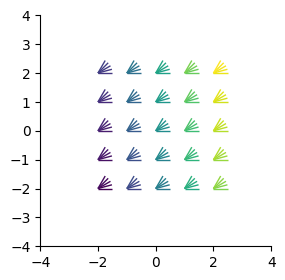

In [18]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(vs[:,:2], 2, ax=ax)
plot_poses(vs, sc, linewidth=1, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [19]:
bb = bounding_box(meshes[13].vertices[:,:2])

console.print(f"""
    Mesh
    width, height =  {bb[1][0] - bb[0][0]:0.2f}, {bb[1][1] - bb[0][1]:0.2f}
""")

Mesh
    width, height =  1.17, 0.93

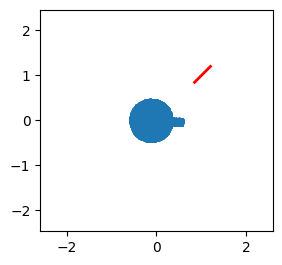

In [20]:
p0 = jnp.array([1.2,1.2,-0.75*jnp.pi])

# ===========
fig, ax = plt.subplots(1,1,figsize=(3,3))
zoom_in(bb, 2, ax=ax)
plt.scatter(*meshes[13].vertices[:,:2].T, s=1)
plot_pose(p0, ax=ax, r=0.5)

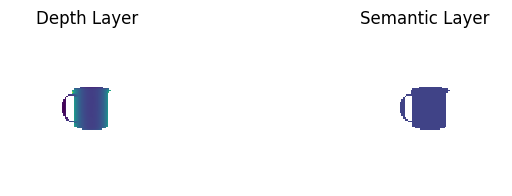

In [21]:
Y0 = render(lift_pose(p0), inds=[13])
im     = np.where(Y0[:,:,2]==20.0, jnp.inf, Y0[:,:,2])
im_sem = np.where(Y0[:,:,3].astype(jnp.float32)==0.0, jnp.inf, Y0[:,:,3])
# # ======================
fig, axs = plt.subplots(1,2,figsize=(8,2))
for ax in axs: ax.axis("off")
axs[0].set_title("Depth Layer")
axs[0].imshow(im)
axs[1].set_title("Semantic Layer")
axs[1].imshow(im_sem,vmin=0, vmax=5)

In [43]:
w     = 5
zmax  = 10.0

sensor_model_type = ["constrained", "baseline"][1]
model = make_model(w, zmax, sensor_model_type)
args0  = (jnp.array([13]),) 
key   = keysplit(key)

# NOTE: `Args` is just my altered version of a named tuple.
# A Gen function consumes an n-tuple of arguments.
# The line could be replaced by `args = (True,)`.

ch0 = make_constraints(Y0, sensor_model_type)
ch0["x"]  = p0[:2]
ch0["hd"] = p0[2]
ch0["sig"] = 0.1
ch0["outlier"] = 0.1

_, tr0 = model.importance(key, ch0, args0)
tr0.score, tr0.args

(Array(-4795.1997, dtype=float32), (Array([13], dtype=int32),))

## Inference

In [23]:
def get_circle(r=1.0, n=100):
    ts = jnp.linspace(0,2*jnp.pi, n)
    return jnp.stack([jnp.cos(ts), jnp.sin(ts), jnp.zeros(n)], axis=1)

In [24]:
def filter_grid(vs, hd=20, r=(0.5,2.0)):
    
    thetas = jnp.arctan2(vs[:,1],vs[:,0])+jnp.pi
    thetas = vmap(adjust_angle)(thetas)
    norms  = jnp.linalg.norm(vs[:,:2], axis=-1)

    th_mask = jnp.abs(vmap(adjust_angle)(thetas - vs[:,2])) < hd/180*jnp.pi
    xy_mask = (r[0]<= norms)*(norms <= r[1])
    vs_ = vs[jnp.where(th_mask * xy_mask)[0]] 
    return vs_

39214


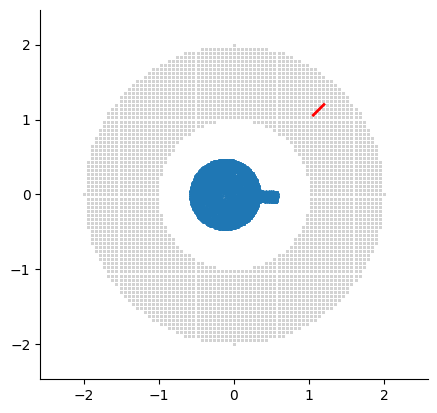

In [29]:
bounds = ((-2., 2.), (-2.,2.), (-jnp.pi, jnp.pi))
vs = get_linear_grid((75, 75, 100), bounds, flat=True)
vs_ = filter_grid(vs, r=(1.,2.), hd=22)

print(len(vs_))
# =======================================
fig, ax = plt.subplots(1,1,figsize=(5,5))
zoom_in(bb, 2., ax=ax)
ax.scatter(*meshes[13].vertices[:,:2].T, s=1)

ax.scatter(*vs_[:,:2].T, c="lightgray", s=1)
plot_pose(p0, ax=ax, r=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [30]:

vs = get_linear_grid((130, 130, 130), bounds, flat=True)
vs_ = filter_grid(vs, r=(1.,2.), hd=22)
vs_.shape

(155400, 3)

In [130]:
# vs = get_linear_grid((30, 30, 30), ((-1., 1.), (-1.,1.), (-10/180*jnp.pi, 20/180*jnp.pi)), flat=True)
# vs_ = vs + p0 
# vs_.shape

(27000, 3)

In [48]:
w     = 5
zmax  = 5.0

sensor_model_type = ["constrained", "baseline"][0]
model = make_model(w, zmax, sensor_model_type)
args0  = (jnp.array([13]),) 
key   = keysplit(key)

# NOTE: `Args` is just my altered version of a named tuple.
# A Gen function consumes an n-tuple of arguments.
# The line could be replaced by `args = (True,)`.

ch0 = make_constraints(Y0, sensor_model_type)
ch0["x"]       = p0[:2]
ch0["hd"]      = p0[2]
ch0["sig"]     = 0.1
ch0["outlier"] = 0.1

_, tr0 = model.importance(key, ch0, args0)
tr0.score, tr0.args

(Array(10902.695, dtype=float32), (Array([13], dtype=int32),))

In [45]:
key = keysplit(key)
sig = 0.1
out = 0.1
sc = eval_pose_batched(key, tr0, vs_[:,:3], sig, out, b=500)
sc = sc - logsumexp(sc)

jnp.sum(jnp.isnan(sc)), jnp.sum(sc==-jnp.inf)


(Array(0, dtype=int32), Array(0, dtype=int32))

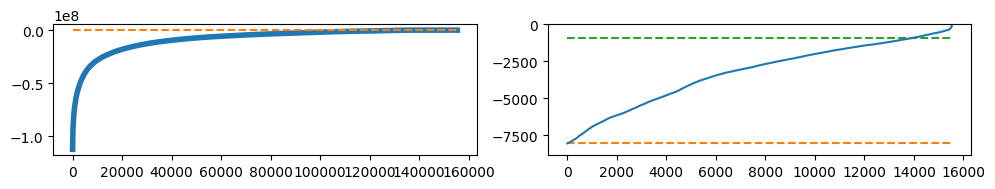

In [46]:
q  = 0.9
q_ = 0.99
quant = jnp.quantile(sc, q)
quant_ = jnp.quantile(sc, q_)

# ===========================
fig, axs = plt.subplots(1,2,figsize=(10,2))
axs[0].plot(jnp.sort(sc), linewidth=4)
axs[0].hlines(jnp.quantile(sc, q), 0, len(vs_), color="C1", linestyle="--", zorder=11)

axs[1].set_ylim(1.1*quant, 1.1*jnp.max(sc))
axs[1].hlines(quant, 0, len(sc[sc>=quant]), color="C1", linestyle="--", zorder=-1)
axs[1].hlines(quant_, 0, len(sc[sc>=quant]), color="C2", linestyle="--", zorder=-1)
axs[1].plot(jnp.sort(sc[sc>=quant]))
fig.tight_layout()

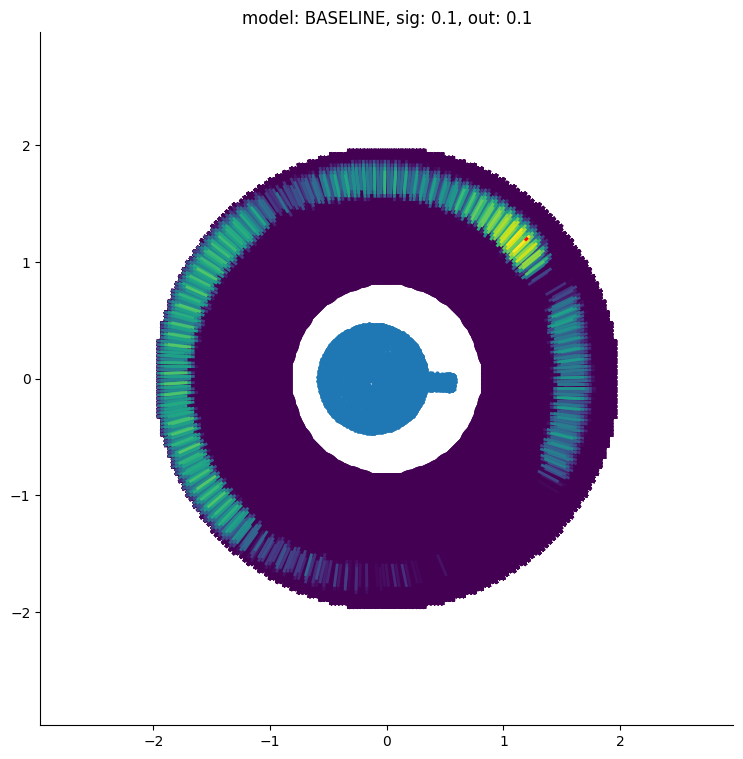

In [47]:
q = 0.99
# =======================================
fig, ax = plt.subplots(1,1,figsize=(9,9))
plt.title(f"model: {sensor_model_type.upper()}, sig: {sig}, out: {out}")
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
# order = jnp.argsort(meshes[13].vertices[:,2])
# ax.scatter(*meshes[13].vertices[order,:2].T, s=1, c=meshes[13].vertices[order,2], cmap="binary")
ax.scatter(*meshes[13].vertices[:,:2].T, s=4)
zoom_in(vs_[:,:2], 1., ax=ax)

plot_poses(vs_, sc, linewidth=2, r=0.2, q=q, clip=-1e6, ax=ax)
# plot_poses(vs_, jnp.exp(sc), linewidth=3, r=0.3, q=0., clip=1e-5, ax=ax)
plot_pose(p0, r=0.1, linewidth=2, ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)